In [45]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 16 12:29:12 2021

@author: hatto
"""

import urllib
import json
import numpy as np
import matplotlib.pyplot as plt
import math
    
#constants

pop = 14789778*0.85 #Population times estimated eligible proportion

#global display parameters

figwidth=15
figheight=7

#some useful functions

def list2np(arglist):
    retlist=[]
    for x in arglist:
        x = np.array(x)
        x = np.where(x == None, np.nan, x) #change the NoneType to nan so numpy will work
        retlist += [x]
    return retlist

def total2daily(arglist):
    retlist=[]
    
    for x in arglist:
        x = np.ndarray.astype(x,dtype=float)
        tmp = np.where(np.logical_and(np.isnan(x[:-1]),
                                      np.logical_not(
                                          np.isnan(x[1:]))), 0, x[:-1] ) #replace the last nan with a 0
        x = np.append(tmp, x[-1]) #return the last element, which was chopped off in previous line
        x = np.append(np.nan, x) #return output to same length as input
        retlist += [x[1:]-x[:-1]]
    return retlist

def rollavg(arglist, n):
    retlist=[]
    
    for x in arglist:
        x = np.convolve(x, np.ones(n), 'valid') / n #take a weekly rolling average
        retlist += [x]
    
    return retlist

def get_sgn(num):
    if num < 0:
        return ''
    else:
        return '+'

#reading data

vacc_url = "https://data.ontario.ca/api/3/action/datastore_search?resource_id=8a89caa9-511c-4568-af89-7f2174b4378c&limit=1000"
case_url = "https://data.ontario.ca/api/3/action/datastore_search?resource_id=ed270bb8-340b-41f9-a7c6-e8ef587e6d11&limit=1000"
re_url = "https://data.ontario.ca/api/3/action/datastore_search?resource_id=1ffdf824-2712-4f64-b7fc-f8b2509f9204&limit=1000"  
vacc_file = urllib.request.urlopen(vacc_url)
case_file = urllib.request.urlopen(case_url)
re_file = urllib.request.urlopen(re_url)
vacc_response = json.loads(vacc_file.read())
case_response = json.loads(case_file.read())
re_response = json.loads(re_file.read())

doses=[]
dose_dates=[]
total_doses=[]
full=[]
cases=[]
case_dates=[]
deaths=[]
re=[]
re_end_dates=[]

for day in vacc_response["result"]["records"]:
    doses += [day["previous_day_total_doses_administered"]]
    dose_dates += [day["report_date"][:-9]]
    total_doses += [day["total_doses_administered"]]
    full += [day["total_individuals_fully_vaccinated"]]

for day in case_response["result"]["records"]:
    cases += [day["Total Cases"]]
    case_dates += [day["Reported Date"][:-9]]
    deaths += [day["Deaths"]]

for day in re_response["result"]["records"]:
    re += [day["Re"]]
    re_end_dates += [day["date_end"][:-9]]
    
#some light processing of data

[total_doses, doses, deaths, cases] = list2np([total_doses, doses, deaths, cases])

full = np.array(full, dtype=float) #why must this be treated differently?
full = np.where(full == None, np.nan, full)

[deaths, cases]=total2daily([deaths, cases])

[doses_avg7, deaths_avg7, cases_avg7] = rollavg([doses, deaths, cases], 7) #7 day avg

#rolling avg removes 6 entries, add them back so lengths match
temp = np.full((6), np.nan)
cases_avg7 = np.append(temp, cases_avg7)
deaths_avg7 = np.append(temp,deaths_avg7)
doses_avg7 = np.append(temp,doses_avg7)

print("Doses last updated: "+dose_dates[-1])
print("Cases last updated: "+case_dates[-1])

Doses last updated: 2021-09-03
Cases last updated: 2021-09-03


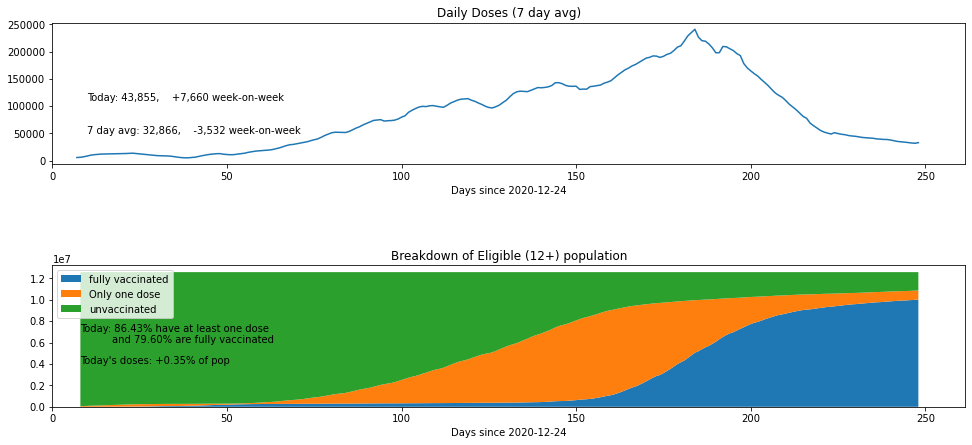

In [31]:
#Vaccines

xx=np.arange(0,len(total_doses), step=1) #for the graph x axes

#daily doses

doses_week_on_week = doses[-1] - doses[-8]
avg_week_on_week = doses_avg7[-1] - doses_avg7[-8]

fig2,ax2=plt.subplots(2,1)
ax2[0].set_title("Daily Doses (7 day avg)")
ax2[0].set_xlabel("Days since "+dose_dates[0])

ax2[0].plot(xx, doses_avg7)
ax2[0].set_xlim([0,1.05*len(xx)])
ax2[0].text(10,110000,"Today: {:,},    {}{:,} week-on-week".format(doses[-1], get_sgn(doses_week_on_week), doses_week_on_week))
ax2[0].text(10,50000,"7 day avg: {:,.0f},    {}{:,.0f} week-on-week".format(doses_avg7[-1], get_sgn(avg_week_on_week), avg_week_on_week))
    
#population breakdown

popvec = np.full(len(xx), pop) #vector filled with total pop
vacc = total_doses - full #number of people with at least one dose
vacc_perc = vacc/pop
unvacc = (popvec - vacc)
one_dose = vacc - full #number of people with only one dose

ax2[1].set_title("Breakdown of Eligible (12+) population")
ax2[1].stackplot(xx, full, one_dose, unvacc)
ax2[1].legend(["fully vaccinated", "Only one dose", "unvaccinated"], loc="upper left")
ax2[1].set_xlabel("Days since " + dose_dates[0])
ax2[1].set_xlim([0,1.05*len(xx)])
ax2[1].text(8,7000000,"Today: {:.2%} have at least one dose".format(vacc_perc[-1]))
ax2[1].text(17,6000000,"and {:.2%} are fully vaccinated".format(full[-1]/pop))
ax2[1].text(8,4000000,"Today's doses: +{:.2%} of pop".format(doses[-1]/pop))

plt.tight_layout()
fig2.set_figwidth(figwidth)
fig2.set_figheight(figheight)

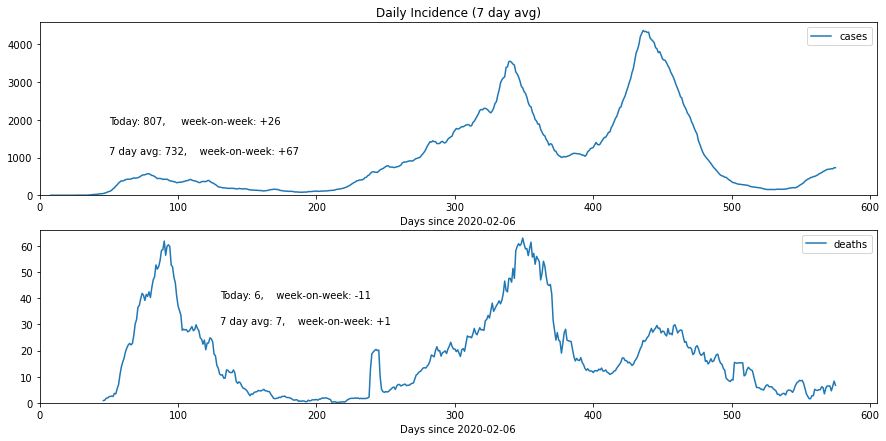

In [44]:
#Cases and deaths

xx2=np.arange(0,len(cases), step=1)

fig4,ax4=plt.subplots(2,1)
ax4[0].plot(xx2,cases_avg7)
ax4[0].set_title("Daily Incidence (7 day avg)")
ax4[0].set_xlabel("Days since "+case_dates[0])
ax4[0].legend(["cases"])
ax4[0].set_xlim([0,1.05*len(xx2)])
ax4[0].set_ylim([0,1.05*np.nanmax(cases_avg7)])
week_on_week=cases[-1] - cases[-8]
ax4[0].text(50, 1900, "Today: {:n},     week-on-week: {}{:n}".format(cases[-1], get_sgn(week_on_week), week_on_week))
avg_week_on_week=cases_avg7[-1]-cases_avg7[-8]
ax4[0].text(50, 1100, "7 day avg: {:.0f},    week-on-week: {}{:.0f}".format(cases_avg7[-1], get_sgn(avg_week_on_week), avg_week_on_week))

ax4[1].plot(xx2,deaths_avg7)
ax4[1].legend(["deaths"])
ax4[1].set_xlim([0,1.05*len(xx2)])
ax4[1].set_ylim([0,1.05*np.nanmax(deaths_avg7)])
ax4[1].set_xlabel("Days since "+case_dates[0])
week_on_week=deaths[-1]-deaths[-8]
ax4[1].text(130, 40, "Today: {:n},    week-on-week: {}{:n}".format(deaths[-1], get_sgn(week_on_week), week_on_week))
avg_week_on_week=deaths_avg7[-1]-deaths_avg7[-8]
ax4[1].text(130, 30, "7 day avg: {:.0f},    week-on-week: {}{:.0f}".format(deaths_avg7[-1], get_sgn(avg_week_on_week), avg_week_on_week))

fig4.set_figwidth(figwidth)
fig4.set_figheight(figheight)

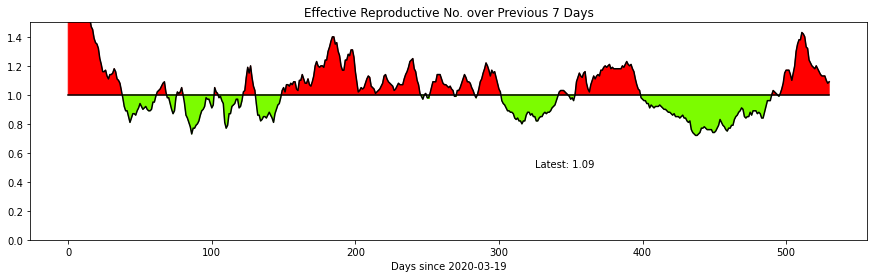

In [33]:
#Reproductive number

#TODO: colour space between Re and 1.
#fill_between with true at points above 1 and colour red
#fill_between with true at points below 1 and colour red

xx3 = np.arange(0,len(re))
baseline = np.full_like(xx3, 1)

fig5,ax5=plt.subplots()
ax5.plot(xx3, re, xx3, baseline, color='black')
ax5.fill_between(xx3, re, baseline, re>=baseline, color='red')
ax5.fill_between(xx3, re, baseline, re<baseline, color='lawngreen')
ax5.set_title("Effective Reproductive No. over Previous 7 Days")
ax5.set_xlabel("Days since "+re_end_dates[0])
ax5.set_ylim([0,1.5])
ax5.text(325,0.5, "Latest: {:.2f}".format(re[-1]))
fig5.set_figwidth(figwidth)